![](https://images.pexels.com/photos/6618/pexels-photo.jpg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# Monocular Video Odometry [Still a Work In Progrees]

Video odometry (VO) is the process of obtaining velocity and positional change from a video stream. The best way to do this is with stereo vision, but it can also be done with one camera or a monocular vision system.

### Algorithm 2D-to-2D

1. Capture new frame $I_k$
1. Extract and match features between $I_{k-1}$
1. Compute essential matrix for image pair $I_{k-1}$, $I_k$
    1. Essential Matrix is computed from features correspondences using epipolar constraint
    1. The matrix has an unknown scale factor (cannot get depth from a single camera)
    1. Commonly solved with Nister Five-Point Alorithm which uses SVD
1. Decompose essential matrix into $R_k$ and $t_k$, and form $T_k$
1. Compute relative scale and rescale $t_k$ accordingly
1. Concatenate transformation by computing $C_k = C_{k-1} T_k$
1. Repeat from 1

- lidar can be used to add depth and coupled with high rate (60Hz) VO


## Data Sets

<img src="passat.png" width="50%">

Data from [KITTI](http://www.cvlibs.net/datasets/kitti/setup.php). If you go to the [Odometry page](http://www.cvlibs.net/datasets/kitti/eval_odometry.php) and download the following data sets (direct links are below): 

- [grayscale (22GB)](http://www.cvlibs.net/download.php?file=data_odometry_gray.zip)
- [calibration (1MB)](http://www.cvlibs.net/download.php?file=data_odometry_calib.zip)
- [ground truth (4MB)](http://www.cvlibs.net/download.php?file=data_odometry_poses.zip)

Note, the video is **big** and why I don't provide a copy of it.

In [1]:
%matplotlib inline 

In [1]:
import cv2          # opencv itself
import numpy as np  # matrix manipulations
# to play an mpeg4 video, you can do this:
from IPython.display import HTML # need this for embedding a movie in an iframe
from matplotlib import pyplot as plt

import pykitti  # this is a modified version of the original, I don't load the lidar data

## Sensor Layout

<img src="setup.png" width="85%">

## Video

As shown in the diagram above, there are two sets of cameras: Point Grey Flea 2 (FL-14S3M-C) 1.4 Megapixel grayscale (0 and 1) and Point Grey Flea 2 (FL-14S3C-C) 1.4 Megapixel color (2, 3) cameras. I am just working with the grayscale, rectified, uncompressed (lossless png is what they say).

In [21]:
def pil2opencv(imgs, hist_equ=False):
    if hist_equ:
        ret = [cv2.equalizeHist(np.array(x)) for x in imgs]
    else:
        ret = [np.array(x) for x in imgs]
    return ret

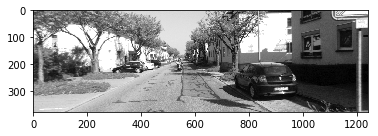

In [22]:
# imgs = readImages('./dataset/sequences/00/image_0/*.png', 200)
dataset = pykitti.odometry('../do_not_backup/dataset', '00', frames=range(300), lidar=False)
imgs = pil2opencv(dataset.cam0, True)

plt.imshow(imgs[0], cmap='gray');

## Ground Truth

In [5]:
tmp = dataset.poses
tp = [(x[0][3],x[2][3],x[1][3],) for x in tmp]
len(tp)

300

Text(0.5,1,'True Position (z) [m]')

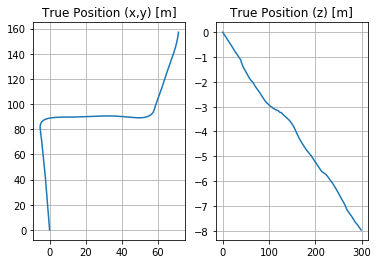

In [10]:
# tp = getTruth('./dataset/poses/00.txt')
tx = [x[0] for x in tp]
ty = [x[1] for x in tp]
tz = [x[2] for x in tp]

plt.subplot(1,2,1)
plt.plot(tx, ty)
plt.grid(True)
plt.title("True Position (x,y) [m]")

plt.subplot(1,2,2)
plt.plot(tz)
plt.grid(True)
plt.title("True Position (z) [m]")

## Video Odometry Setup

In [11]:
def run(images, ground_truth):
    #initialization
#     ground_truth =getTruePose()

    img_1 = images[0]
    img_2 = images[0]

    if len(img_1) == 3:
        gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
        gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
    else:
        gray_1 = img_1
        gray_2 = img_2

    #find the detector
    detector = featureDetection()
    kp1      = detector.detect(img_1)
    p1       = np.array([kp.pt for kp in kp1],dtype='float32')
    p1, p2   = featureTracking(gray_1, gray_2, p1)

    #Camera parameters
    fc = 718.8560
    pp = (607.1928, 185.2157)
    K  = getK()

    E, mask = cv2.findEssentialMat(p2, p1, fc, pp, cv2.RANSAC,0.999,1.0);
    _, R, t, mask = cv2.recoverPose(E, p2, p1,focal=fc, pp = pp);

    #initialize some parameters
    MAX_FRAME     = 200
    MIN_NUM_FEAT  = 1500

    preFeature = p2
    preImage   = gray_2

    R_f = R
    t_f = t

    maxError = 0
    ret_pos = []
    
    for numFrame in range(2, MAX_FRAME):

        if numFrame % 20 == 0:
            print(numFrame)

        if (len(preFeature) < MIN_NUM_FEAT):
            feature   = detector.detect(preImage)
            preFeature = np.array([ele.pt for ele in feature],dtype='float32')

        curImage_c = images[numFrame]

        if len(curImage_c) == 3:
              curImage = cv2.cvtColor(currImage_c, cv2.COLOR_BGR2GRAY)
        else:
              curImage = curImage_c

        kp1 = detector.detect(curImage);
        preFeature, curFeature = featureTracking(preImage, curImage, preFeature)
        E, mask = cv2.findEssentialMat(curFeature, preFeature, fc, pp, cv2.RANSAC,0.999,1.0);
        _, R, t, mask = cv2.recoverPose(E, curFeature, preFeature, focal=fc, pp = pp);

        truth_x, truth_y, truth_z, absolute_scale = getAbsoluteScale(
            ground_truth[numFrame-1], ground_truth[numFrame])
        
        if numFrame % 20 == 0:
            print('scale', absolute_scale)

        absolute_scale = 1.0
            
        if absolute_scale > 0.1:
            t_f = t_f + absolute_scale*R_f.dot(t)
            R_f = R.dot(R_f)
        else:
            print("crap ... bad scale:", absolute_scale)

        preImage = curImage
        preFeature = curFeature

        ret_pos.append((t_f[0], t_f[2]))

    return ret_pos

In [12]:
def featureDetection():
    thresh = dict(threshold=25, nonmaxSuppression=True);
    fast = cv2.FastFeatureDetector_create(**thresh)
    return fast

In [13]:
def getAbsoluteScale(f0, f1):
      x_pre, y_pre, z_pre = f0
      x    , y    , z     = f1
      scale = np.sqrt((x-x_pre)**2 + (y-y_pre)**2 + (z-z_pre)**2)
      return x, y, z, scale

def featureTracking(img_1, img_2, p1):

    lk_params = dict( winSize  = (21,21),
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
    st = st.reshape(st.shape[0])
    ##find good one
    p1 = p1[st==1]
    p2 = p2[st==1]

    return p1,p2

In [14]:
# rotation matrix for camera 0 relative to global?
# see calib.txt in dataset/sequences/00
def getK():
    return   np.array([[7.188560000000e+02, 0, 6.071928000000e+02],
              [0, 7.188560000000e+02, 1.852157000000e+02],
              [0, 0, 1]])

# Run

In [24]:
pts = run(imgs, tp)

20
scale 0.9017212569254713
40
scale 1.0604483140860739
60
scale 0.9610094431050095
80
scale 0.7159971775712494
100
scale 0.4387067566404637
120
scale 0.3856944798834438
140
scale 0.655036308257794
160
scale 0.8127068567011079
180
scale 0.7240527333005461


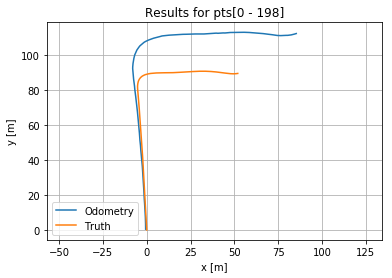

In [25]:
cx = [x[0] for x in pts]
cy = [x[1] for x in pts]
plt.plot(cx, cy, label='Odometry')


tx = [x[0] for x in tp[:len(cx)]]
ty = [x[1] for x in tp[:len(cx)]]
tz = [x[2] for x in tp[:len(cx)]]
plt.plot(tx,ty, label='Truth')

plt.title('Results for pts[0 - {}]'.format(len(cx)))
plt.grid(True)
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend();